In [19]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
import winsound
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, isa_vit_metric

### Monitoring and CUDA Setup


In [20]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/10_epochs_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_18_2024_204646'

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Config for RPN and ViT Fitter


In [22]:
from project.model import RPN, ISAVIT

rpn_config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
        # pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.SmoothL1Loss(),
    'lr': 0.0001
}

324


In [23]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=16,
        dim_ff=1600
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.BCEWithLogitsLoss(),
    'lr': 0.0001
}

### Dataset Loading


In [24]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [25]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


### Preprocessing and Train-Test Split Function


In [26]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                ):
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

### RPN Fitter


In [27]:
from project import Fitter

In [28]:
class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric
                

### ViT Fitter


In [29]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader, stage1):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader, stage1)
            val_loss, val_metric = self.validation(val_loader, stage1)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader, stage1):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(self.device)
                masks = masks.float().to(self.device)

                with torch.inference_mode():
                    x, t = stage1(slices, masks, target)
                
                # self.log(f'{x.requires_grad}, {t.requires_grad}')
                # self.log(f'{x.shape}, {t.shape}')

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                
                # print('Prediction:', (y.sigmoid() >= 0.5).int().unique())
                # print('Truth:', (t[target] >= 0).int().unique())

                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {dice_score, precision_score, recall_score, f1_score, fpr}')

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader, stage1):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    x, t = stage1(slices, masks, target)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

### Train-Test Split


In [30]:
rpn_t1, rpn_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=True
)

rpn_t3, rpn_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=True
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [31]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [32]:
from torch.utils.data import ConcatDataset

rpn_train_set = ConcatDataset([rpn_t1, rpn_t3])
rpn_test_set = ConcatDataset([rpn_v1, rpn_v3])

print(f'RPN Train Set Size: {rpn_train_set}')
print(f'RPN Test Set Size: {rpn_test_set}')

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

RPN Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000027FE06BAE10>
RPN Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000027FEFFECF10>
ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000027FE06DBC50>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000027FDEC70AD0>


### K-Fold Cross Validation


In [33]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [35]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

image_size = 300
patch_size = 16

In [36]:
rpn_fold_metrics = []
vit_fold_metrics = []

fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(rpn_train_set)):
    print(f'Fold {i + 1}/{5}')
    
    # RPN
    rpn_config['model'] = RPN(
        input_dim=512,
        output_dim=4,
        image_size=image_size,
        nh=4,
    ).to(device)
    
    rpn_fitter = RPNFitter(rpn_config, logger=logger)
    
    rpn_train_subset = Subset(rpn_train_set, train_index)
    rpn_val_subset = Subset(rpn_train_set, val_index)
    
    rpn_train_subset_dl = DataLoader(
        rpn_train_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    rpn_val_subset_dl = DataLoader(
        rpn_val_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    rpn_thist, rpn_vhist, rpn_tmhist, rpn_vmhist = rpn_fitter.fit(rpn_train_subset_dl, rpn_val_subset_dl)
    
    rpn_fold_metrics.append({
        'fold': i + 1,
        'training_history': rpn_thist,
        'validation_history': rpn_vhist,
        'training_metrics': rpn_tmhist,
        'validation_metrics': rpn_vmhist
    })
    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)
    torch.save(rpn_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/rpn_fold{i+1}.pt')
    
    # FEEDER
    
    resize = get_transform(
        height=patch_size,
        width=patch_size,
        p=1.0,
        rpn_mode=False
    )

    feeder = Feeder(resize)
    stone = GCRPN(
        rpn=rpn_fitter.model,
        feeder=feeder,
        image_size=image_size,
        patch_size=patch_size
    ).to(device)
    
    # ViT
    
    vit_config['model'] = ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600
    ).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl, stone)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================


Fold 1/5
324


d:\Programming Files\Python\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.037164267152547836

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.02058771811425686

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.017208803445100784

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.0658606377366031
INFO:kess:Avg Precision: 0.16034887843476286
INFO:kess:Avg Recall: 0.08610230526918995
INFO:kess:Avg F1: 0.10039832956029167
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.3016414619982243
INFO:kess:Avg Precision: 0.3956128274401029
INFO:kess:Avg Recall: 0.5783393363157908
INFO:kess:Avg F1: 0.4344387466708819
IN

Fold 2/5
324


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.021387942135334015

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.012950402684509754

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.011983185075223446

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.148264331678892
INFO:kess:Avg Precision: 0.37271512261238593
INFO:kess:Avg Recall: 0.22009672116134957
INFO:kess:Avg F1: 0.2278726155436116
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.2757479943335056
INFO:kess:Avg Precision: 0.3047243398924669
INFO:kess:Avg Recall: 0.7635918805996577
INFO:kess:Avg F1: 0.4176533579826355
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.010601585730910301

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.015183663927018642

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current err

Fold 3/5
324


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.02538936771452427

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.01658262498676777

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error:	0.01347647700458765

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.11879518024968626
INFO:kess:Avg Precision: 0.23992311796334026
INFO:kess:Avg Recall: 0.1694363450454869
INFO:kess:Avg F1: 0.1724579434175494
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.2839017197489738
INFO:kess:Avg Precision: 0.3801276981830597
INFO:kess:Avg Recall: 0.5303055216868718
INFO:kess:Avg F1: 0.4209111193815867
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.014980762265622616

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.016246629878878593

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	18
INFO:kess:Current error

Fold 4/5
324


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.027753060683608055

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.01657022535800934

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	0.010154617950320244

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.1356406705511953
INFO:kess:Avg Precision: 0.30536003372931886
INFO:kess:Avg Recall: 0.2418637351329997
INFO:kess:Avg F1: 0.20570434770034823
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.2736692359404905
INFO:kess:Avg Precision: 0.34006787836551666
INFO:kess:Avg Recall: 0.6304487373147692
INFO:kess:Avg F1: 0.40207022641386303
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.013575642369687557

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.013268045149743557

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current e

Fold 5/5
324


INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.03136448934674263

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.01850612834095955

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current error:	0.011023866944015026

INFO:kess:
Training Evaluation Metric:
INFO:kess:Avg IOU: 0.10805727153132527
INFO:kess:Avg Precision: 0.27065194372908546
INFO:kess:Avg Recall: 0.16981158978542535
INFO:kess:Avg F1: 0.16588079279004517
INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.2778969079788242
INFO:kess:Avg Precision: 0.2915412988513708
INFO:kess:Avg Recall: 0.7742031982966832
INFO:kess:Avg F1: 0.4014625432235854
INFO:kess:EPOCH 1 ==============================
INFO:kess:Batch:	1/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.013268426060676575

INFO:kess:Batch:	2/3
INFO:kess:Batch samples:	20
INFO:kess:Current error:	0.014794799499213696

INFO:kess:Batch:	3/3
INFO:kess:Batch samples:	19
INFO:kess:Current er

In [37]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


`rpn_fold_metrics[i]`

- represents each fold

`rpn_fold_metrics[1].keys()`

- 'fold', 'training_history', 'validation_history', 'training_metrics', 'validation_metrics'

`rpn_fold_metrics[1]['training_metrics'][i]`

- represents each epoch

`rpn_fold_metrics[1]['training_metrics'][1].keys()`

- 'iou_score', 'precision_score', 'recall_score', 'f1_score'


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [39]:
def plot_metric_history(fold_metrics, metric, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(len(rpn_fold_metrics)):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        sns.lineplot(x=range(1, len(train)+1), y=train, label=f'Training {metric}', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label=f'Validation {metric}', ax=ax)
    
    
        ax.set_title(f'{title}Training and Validation {metric}: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        
    plt.tight_layout()  
    plt.show()

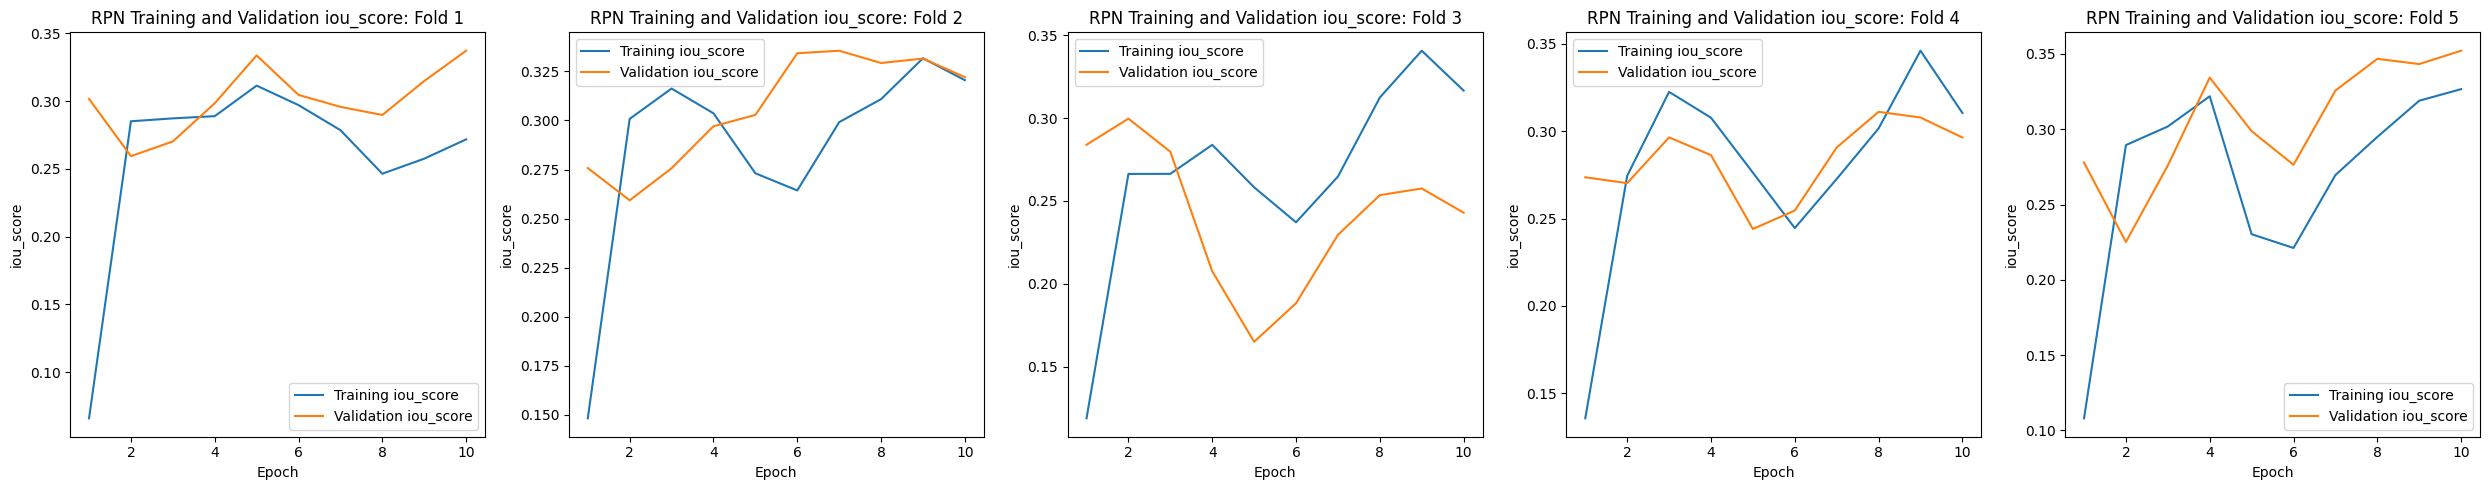

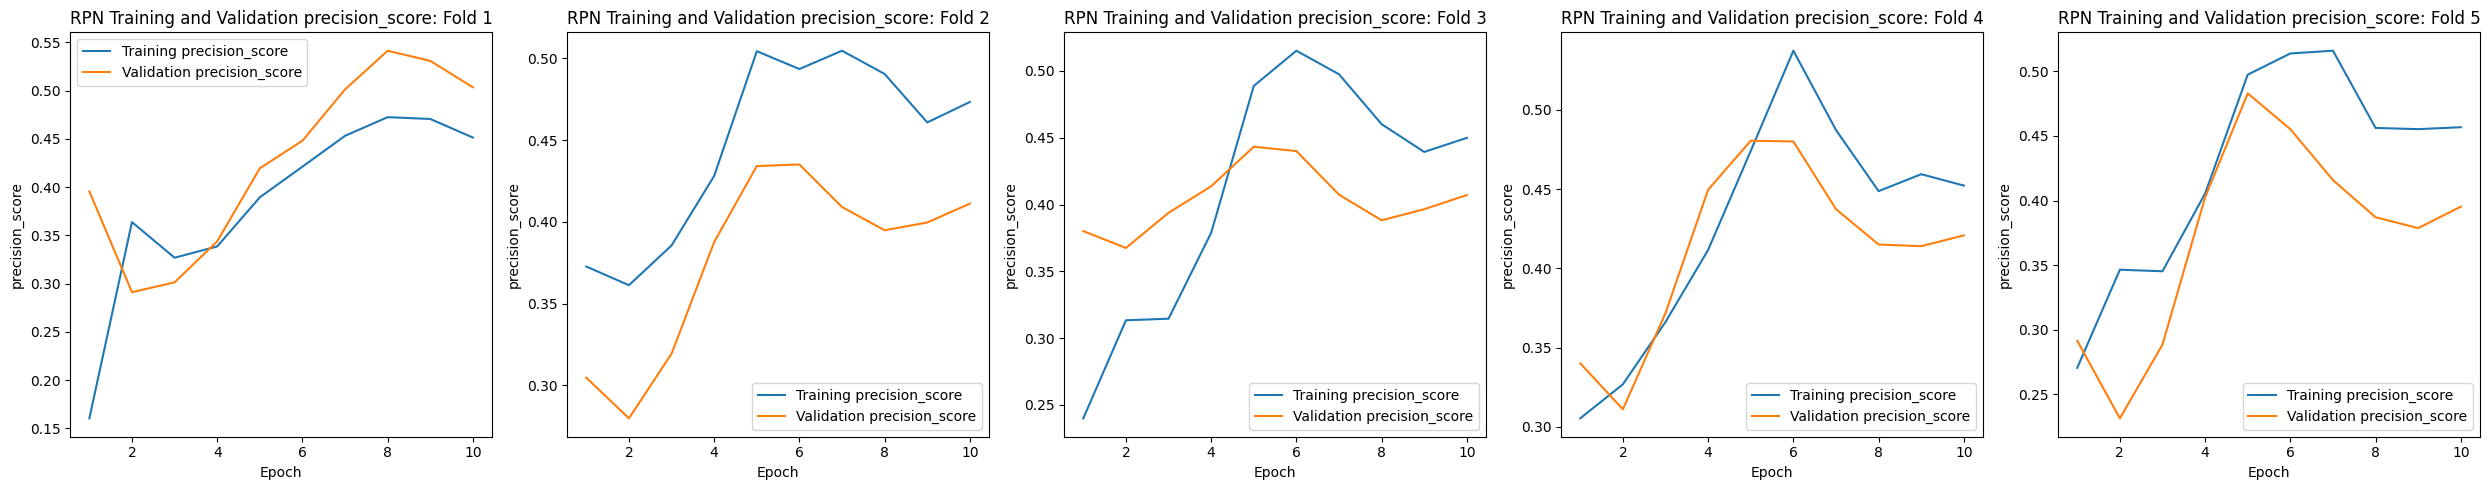

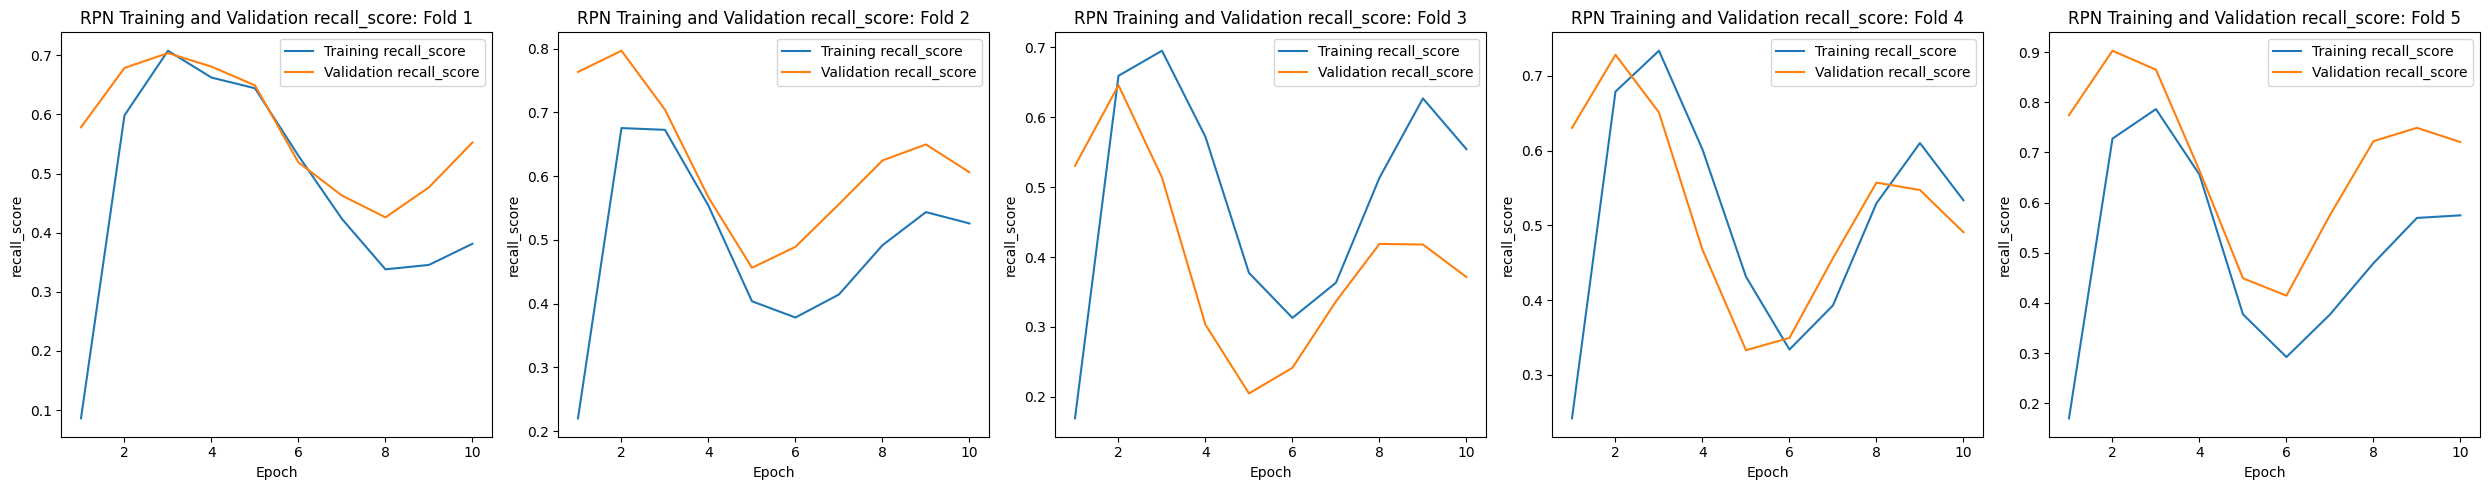

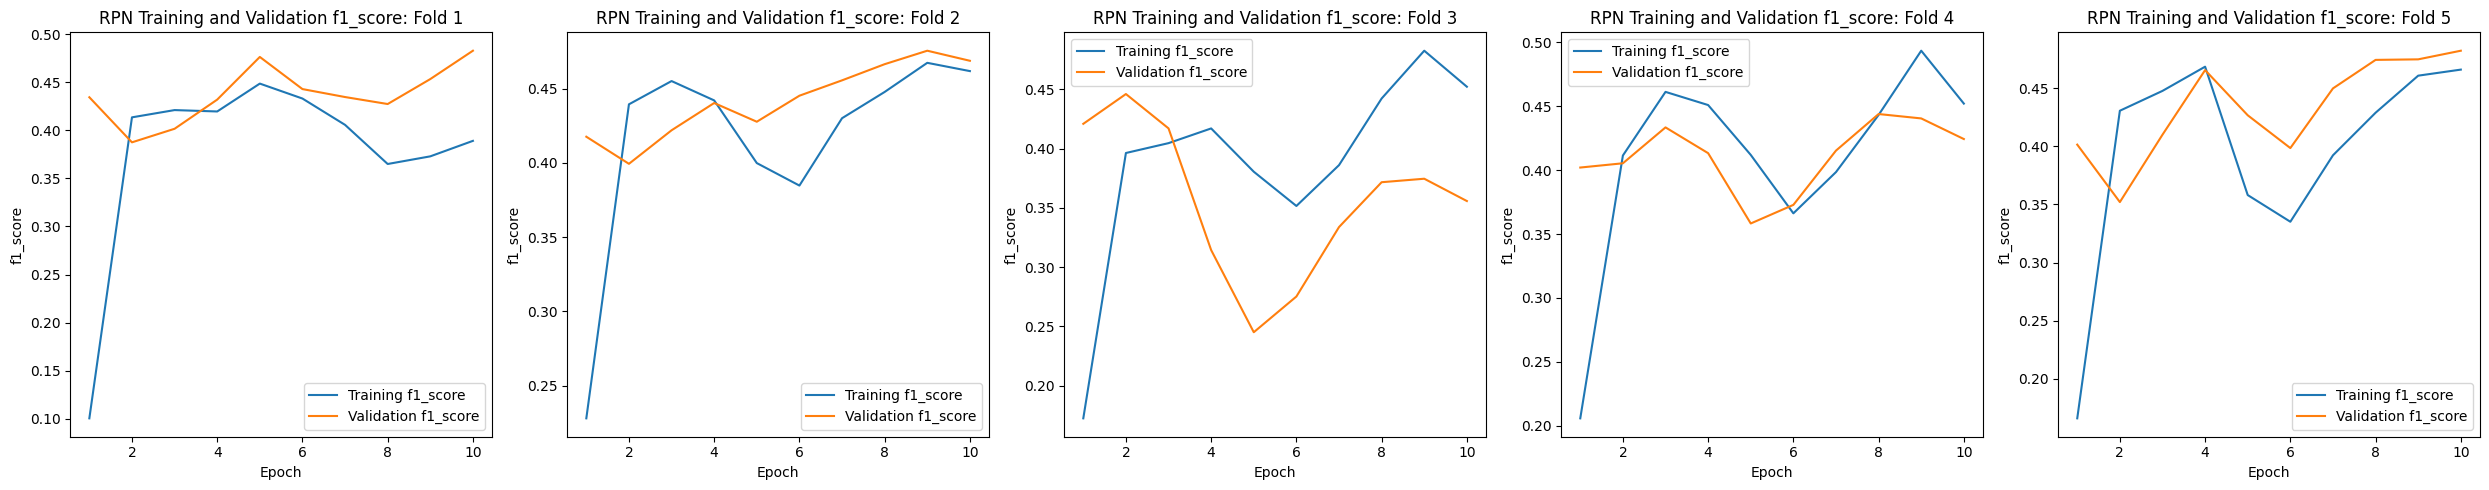

In [40]:
rpn_metrics = ['iou_score', 'precision_score', 'recall_score', 'f1_score']

for metric in rpn_metrics:
    plot_metric_history(rpn_fold_metrics, metric, 'RPN ')

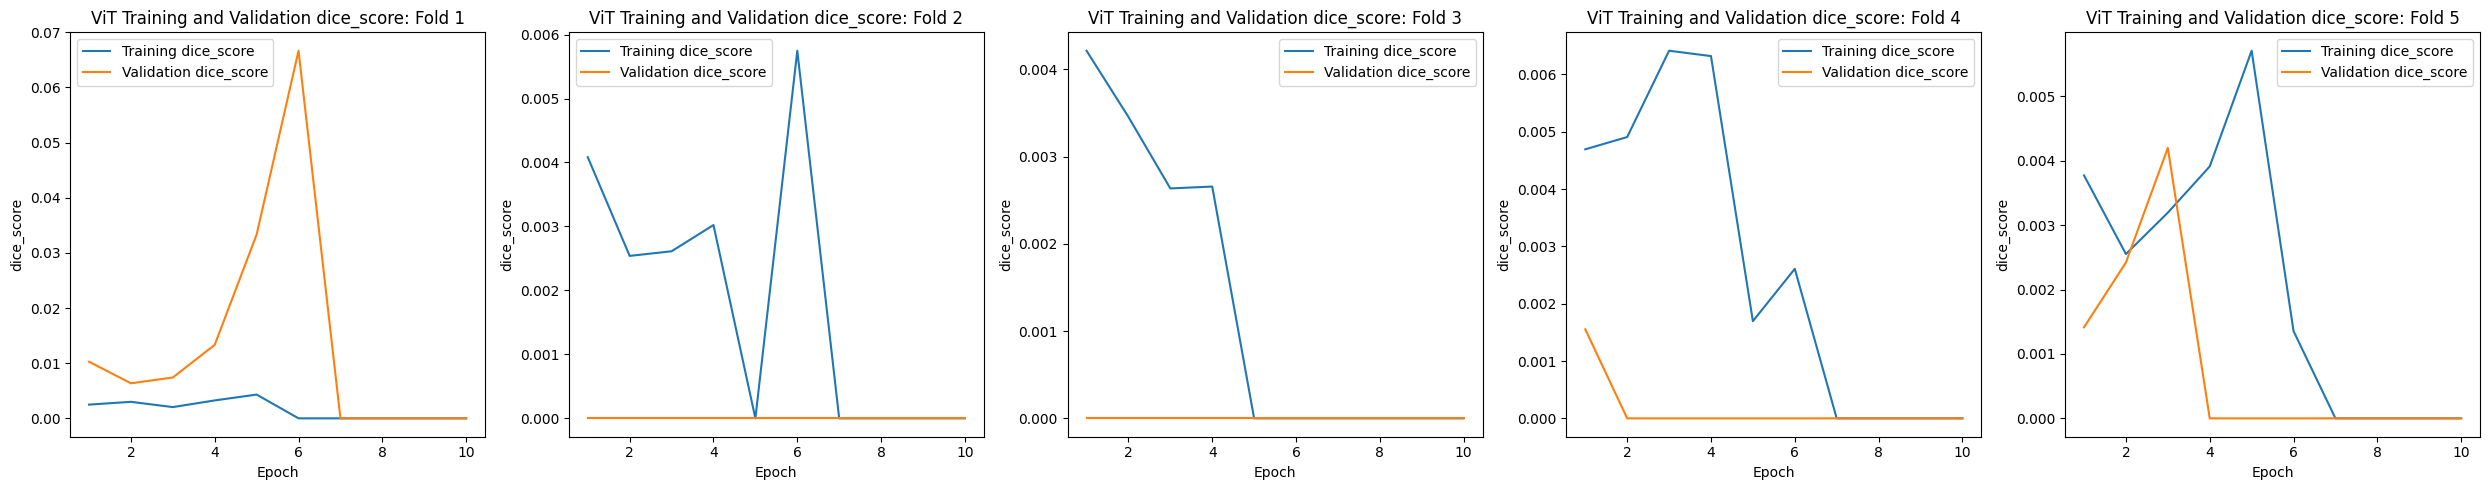

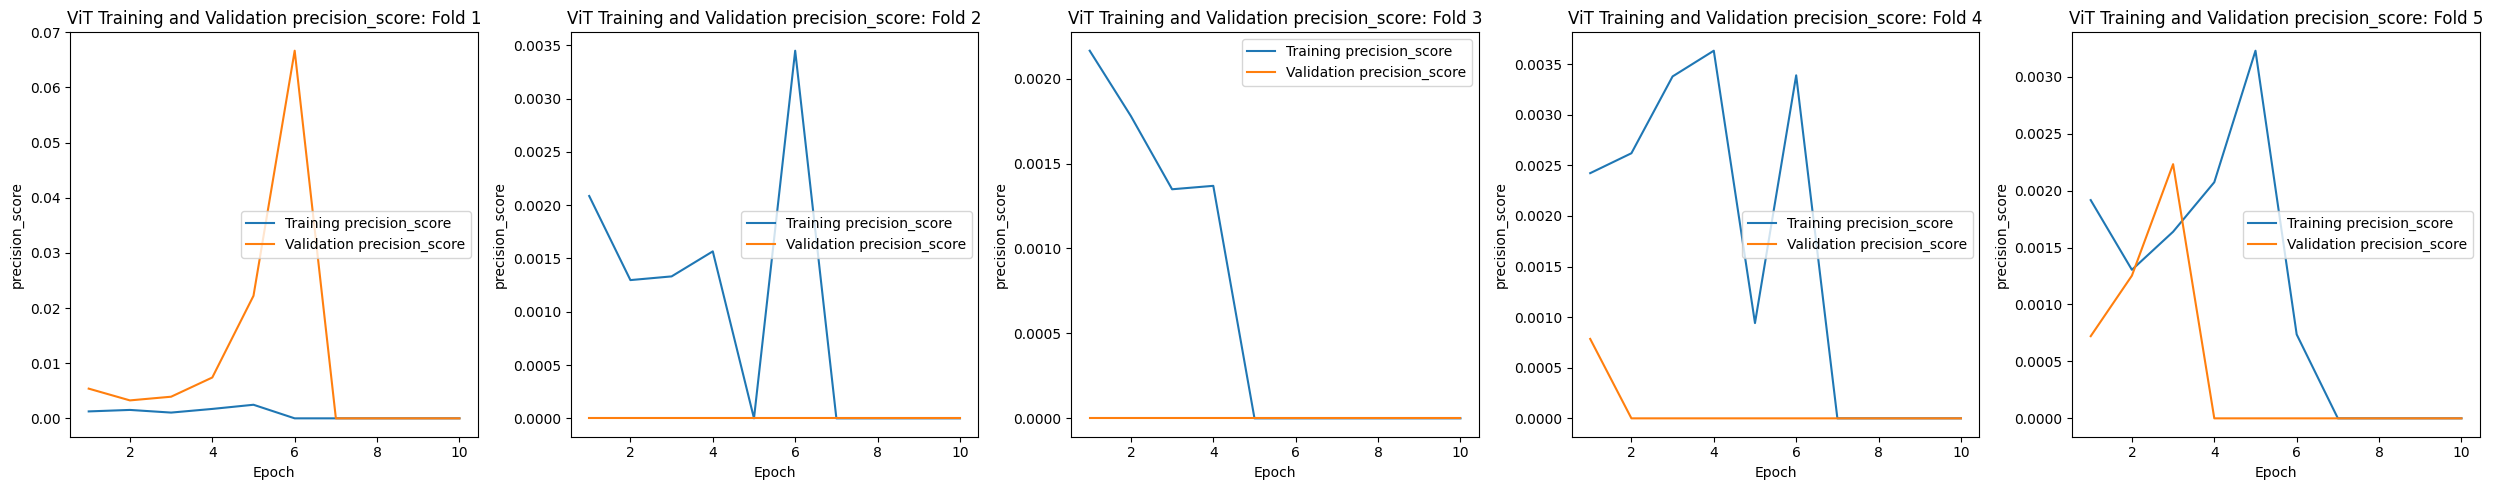

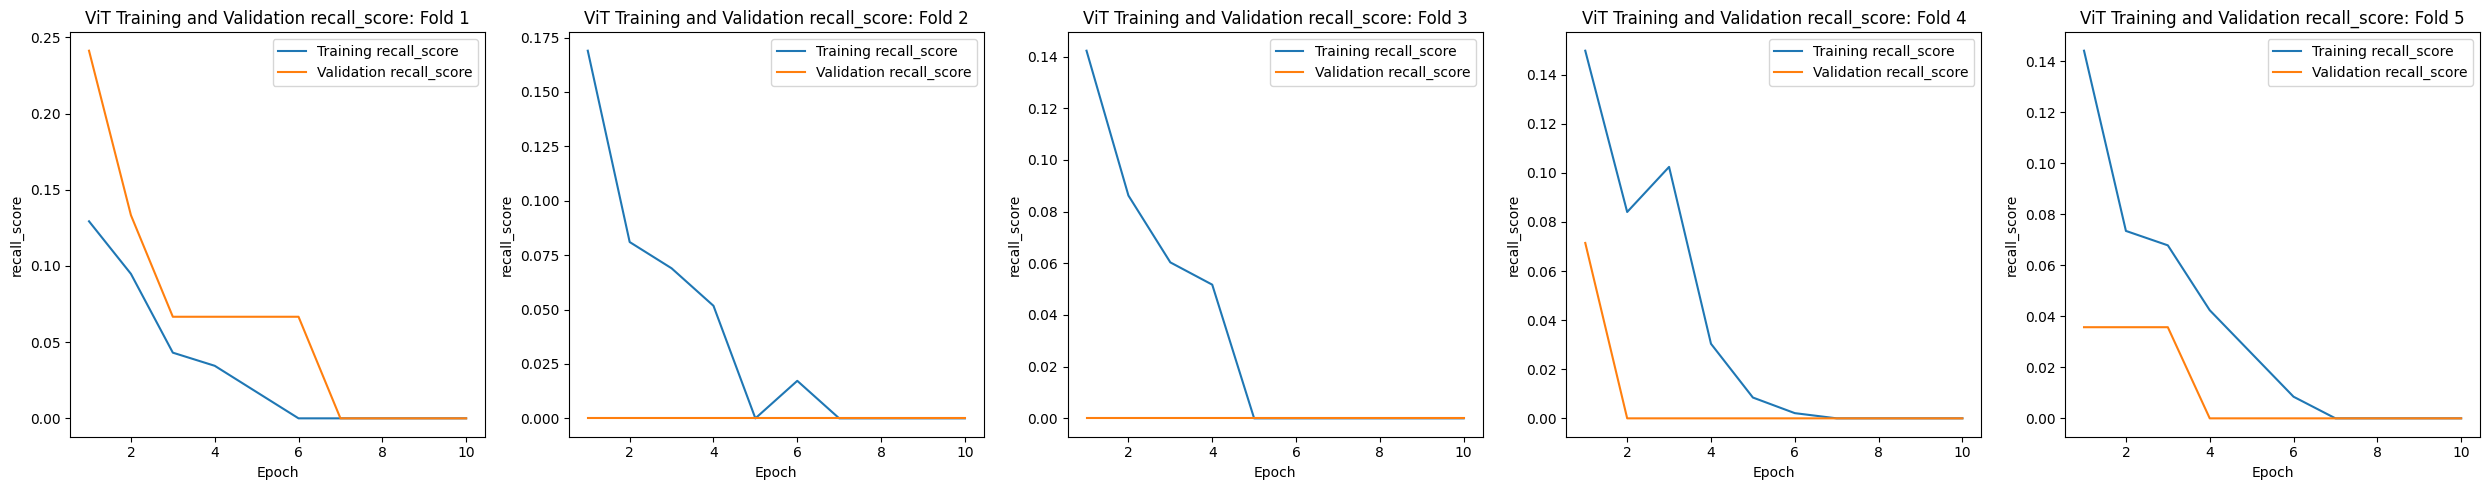

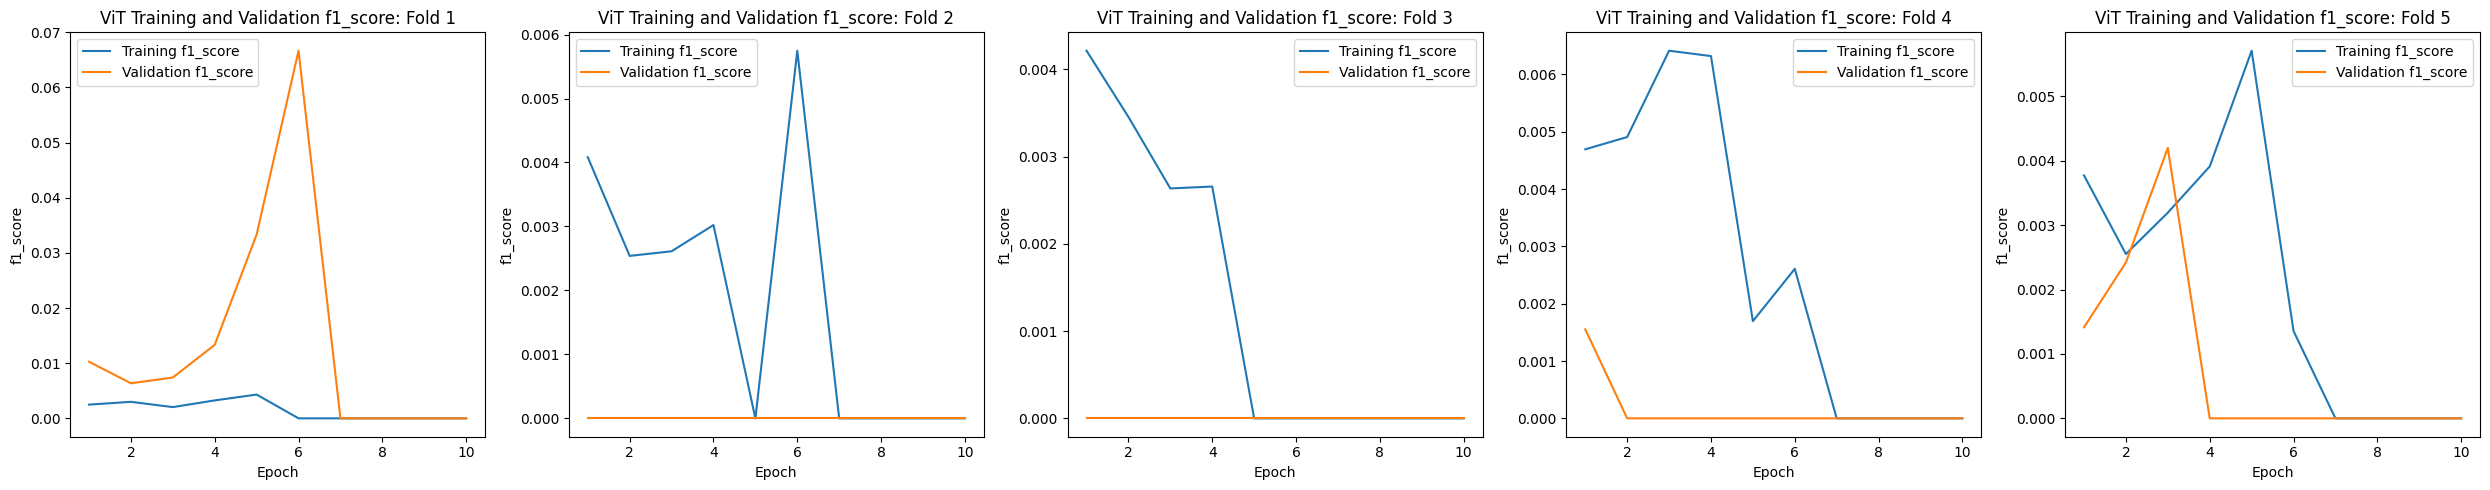

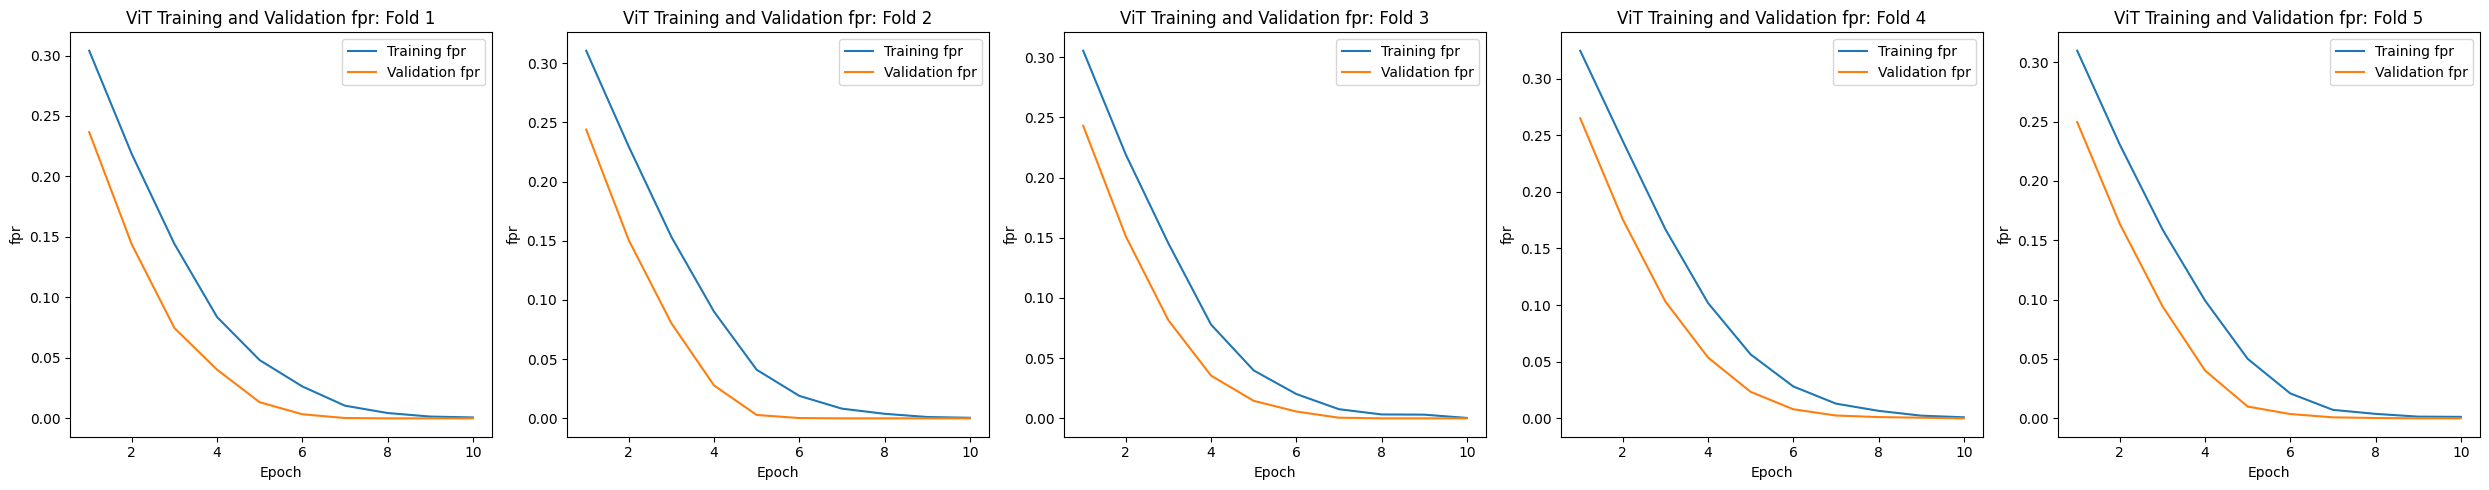

In [41]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [42]:
def plot_loss_history(fold_metrics, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(5):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
        
        sns.lineplot(x=range(1, len(train)+1), y=train, label='Training history', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label='Validation history', ax=ax)
        
        ax.set_title(f'{title}Training and Validation History: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
    
    plt.tight_layout()  
    plt.show()

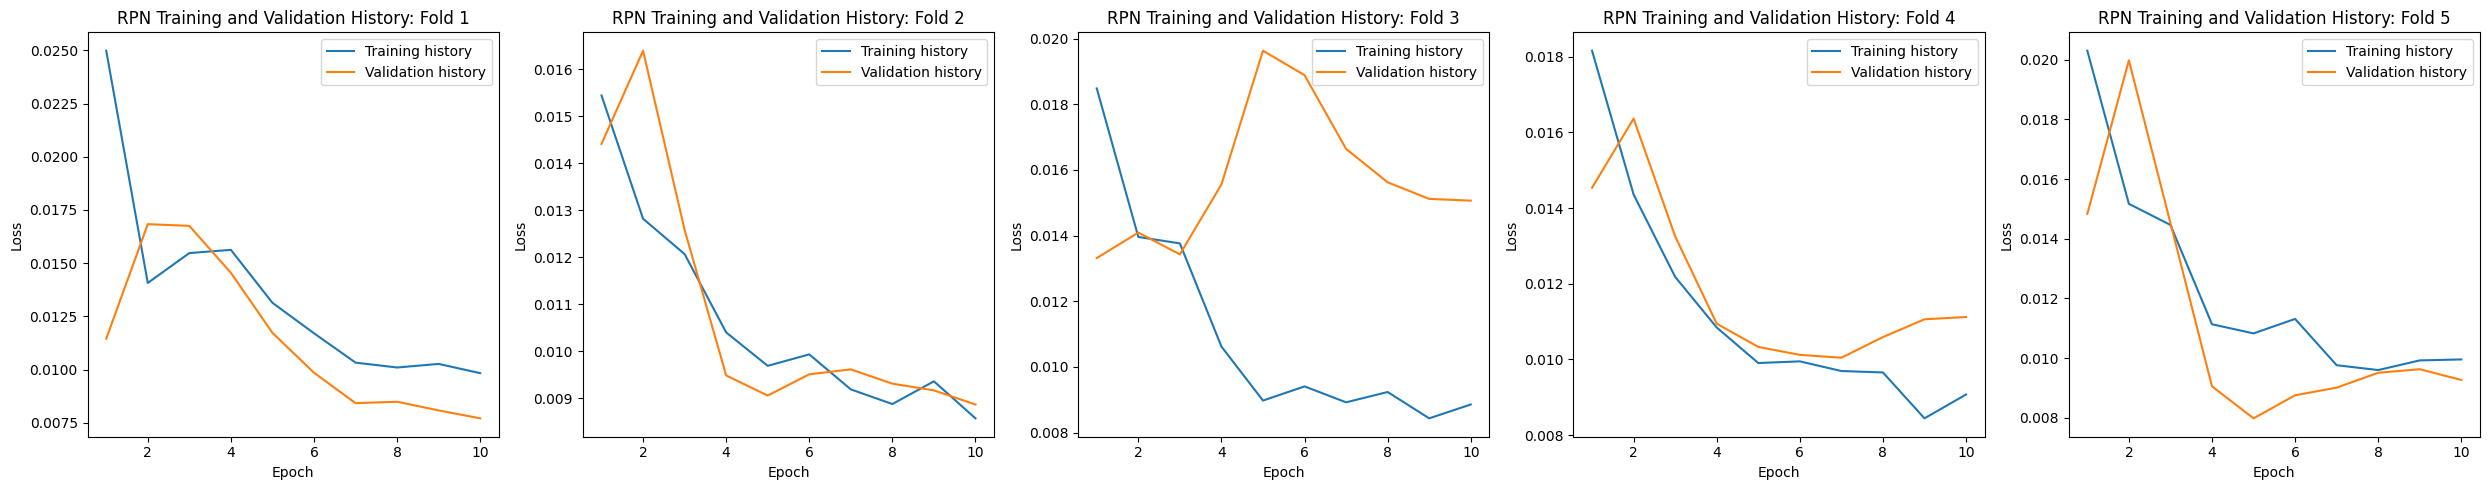

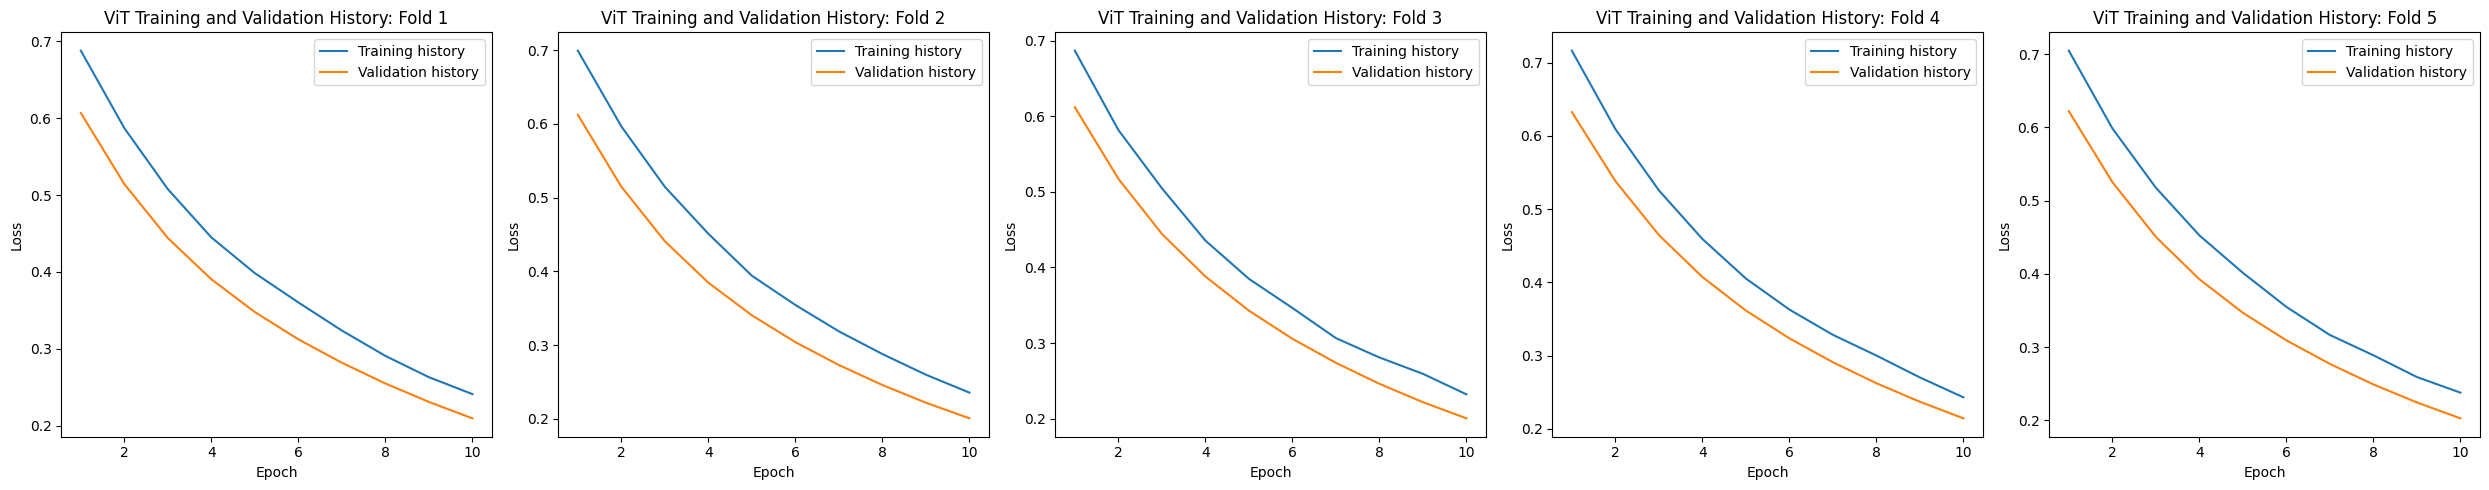

In [43]:
plot_loss_history(rpn_fold_metrics, 'RPN ')
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


In [44]:
rpn_test_dataloader = DataLoader(
    rpn_test_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)

#### RPN


In [45]:
rpn_test_iou = []
rpn_test_precision = []
rpn_test_recall = []
rpn_test_f1 = []

for i, fold in enumerate(os.listdir(fold_dir)):
    print(f'Version rpn_fold{i+1}:')
    rpn_fitter.model.load_state_dict(torch.load(f'{fold_dir}/{fold}/rpn_fold{i+1}.pt'))
    
    rpn_h, rpn_mh = rpn_fitter.validation(rpn_test_dataloader)
    rpn_valmets = pd.DataFrame(rpn_mh)
    rpn_mets = rpn_valmets.mean()
    
    rpn_test_iou.append(rpn_mets.iou_score)
    rpn_test_precision.append(rpn_mets.precision_score)
    rpn_test_recall.append(rpn_mets.recall_score)
    rpn_test_f1.append(rpn_mets.f1_score)
    
    print('\n========================\n')

Version rpn_fold1:


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.24987390509953625
INFO:kess:Avg Precision: 0.38488481576113326
INFO:kess:Avg Recall: 0.4352021629088803
INFO:kess:Avg F1: 0.37198618750431034




Version rpn_fold2:


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.2815587101014037
INFO:kess:Avg Precision: 0.40522863617853117
INFO:kess:Avg Recall: 0.5258941760188655
INFO:kess:Avg F1: 0.4177138738726315




Version rpn_fold3:


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.23998985341505
INFO:kess:Avg Precision: 0.36776261796292503
INFO:kess:Avg Recall: 0.44332639794600637
INFO:kess:Avg F1: 0.35919782303665815




Version rpn_fold4:


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.2811396412159267
INFO:kess:Avg Precision: 0.39597332948132563
INFO:kess:Avg Recall: 0.5403356246258083
INFO:kess:Avg F1: 0.416042317685328




Version rpn_fold5:


INFO:kess:
Validation Evaluation Metric:
INFO:kess:Avg IOU: 0.2765668953131688
INFO:kess:Avg Precision: 0.37424234163604286
INFO:kess:Avg Recall: 0.5357608524592299
INFO:kess:Avg F1: 0.4077356000872035


In [46]:
rpn_iou_score = np.array(rpn_test_iou).mean()
rpn_precision_score = np.array(rpn_test_precision).mean()
rpn_recall_score = np.array(rpn_test_recall).mean()
rpn_f1_score = np.array(rpn_test_f1).mean()

print('RPN Test Set Performance Metrics')
print(f'Average IOU: {rpn_iou_score} ')
print(f'Average Precision: {rpn_precision_score} ')
print(f'Average Recall: {rpn_recall_score} ')
print(f'Average F1 Score: {rpn_f1_score} ')

RPN Test Set Performance Metrics
Average IOU: 0.2658258010290171 
Average Precision: 0.3856183482039916 
Average Recall: 0.49610384279175807 
Average F1 Score: 0.3945351604372263 


#### ViT


In [47]:
# vit_test_iou = []
vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

for i, fold in enumerate(os.listdir(fold_dir)):
    print(f'Version vit_fold{i+1}:')
    vit_fitter.model.load_state_dict(torch.load(f'{fold_dir}/{fold}/vit_fold{i+1}.pt'))
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader, stone)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    # vit_test_iou.append(vit_mets.iou_score)
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)
    
    print('\n========================\n')

Version vit_fold1:


INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0
INFO:kess:Avg Precision: 0.0
INFO:kess:Avg Recall: 0.0
INFO:kess:Avg F1: 0.0
INFO:kess:Avg FPR: 0.0





Version vit_fold2:


INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0
INFO:kess:Avg Precision: 0.0
INFO:kess:Avg Recall: 0.0
INFO:kess:Avg F1: 0.0
INFO:kess:Avg FPR: 0.0





Version vit_fold3:


INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0
INFO:kess:Avg Precision: 0.0
INFO:kess:Avg Recall: 0.0
INFO:kess:Avg F1: 0.0
INFO:kess:Avg FPR: 0.0





Version vit_fold4:


INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0
INFO:kess:Avg Precision: 0.0
INFO:kess:Avg Recall: 0.0
INFO:kess:Avg F1: 0.0
INFO:kess:Avg FPR: 0.0





Version vit_fold5:


INFO:kess:
Validations Evaluation Metric:
INFO:kess:Avg Dice: 0.0
INFO:kess:Avg Precision: 0.0
INFO:kess:Avg Recall: 0.0
INFO:kess:Avg F1: 0.0
INFO:kess:Avg FPR: 0.0



In [48]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.0 
Average Precision: 0.0 
Average Recall: 0.0 
Average F1 Score: 0.0 
Average FPR: 0.0 


## TODO:


Task 3: Add the tracker
